In [1]:
%load_ext autoreload
%autoreload 2
import splitwavepy as sw
import matplotlib.pyplot as plt
import numpy as np


In [2]:
fast, lag = 30, 1.2
split = (fast, lag)
noise = 0.01
d = sw.Data(split=split, noise=noise)
m = d.Meas()

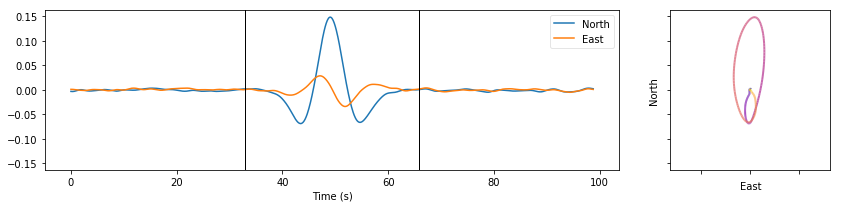

In [3]:
d.plot()


In [4]:
m.data._wrap_unsplit_rotate_back()

TypeError: _wrap_unsplit_rotate_back() missing 2 required positional arguments: 'fast' and 'lag'

In [ ]:
m = data.Meas()
plt.contourf(*m._grid, m.bslam2pdf())
plt.show()


In [ ]:
# fast, lag = 30, 1.2
# split = (fast, lag)
# noise = 0.02
# d = sw.Data(split=split, noise=noise)
m = d.Meas()

plt.contourf(*m._grid, m.bszrhopdf())
plt.title('rho bootstrap')
plt.show()

plt.title('rho f-test')
plt.contourf(*m._grid, m.fzrhopdf())
plt.show()

plt.contourf(*m._grid, m.bslam2pdf())
plt.title('lam2 bootstrap')
plt.show()

plt.contourf(*m._grid, m.flam2pdf())
plt.title('lam2 f-test')
plt.show()

In [ ]:
%timeit m.flam2pdf()

In [ ]:
%timeit m.bszrhopdf

In [ ]:
pol = unsplit._estimate_pol()
unsplit.rotateto(pol)._chopxy()

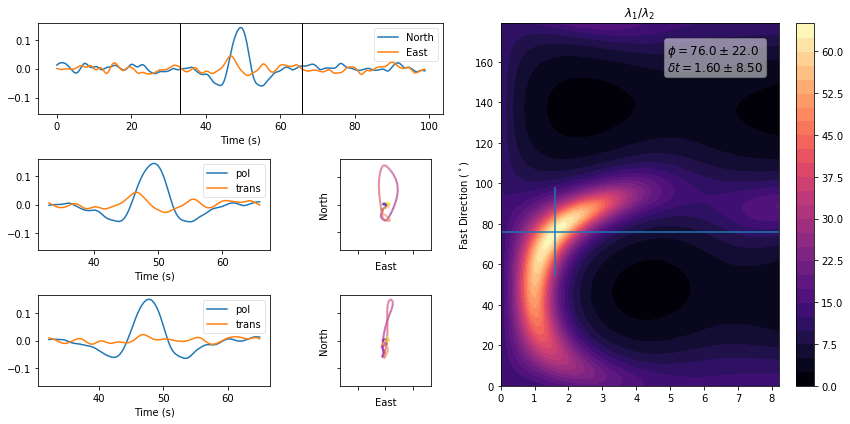

In [19]:
fast, lag = 30, 1.2
split = (fast, lag)
noise = 0.05
data = sw.Data(split=split, noise=noise)
m = data.Meas()
m.plot()

In [ ]:
vals = m.lam2
fast, lag = m._fast_lag_minloc(vals)
print(fast, lag)

In [ ]:
m.silver_chan()
m.cross_corr()

In [ ]:
m.silver_chan()

In [ ]:
vals = m.zrho
fast, lag = m._fast_lag_maxloc(vals)
ndf = m.ndf(fast, lag)
ftestalpha = m.ftest_max(vals, ndf, 0.05)


In [ ]:
ftestalpha.max()

In [ ]:
m.report()

In [ ]:
m.splitting_intensity()

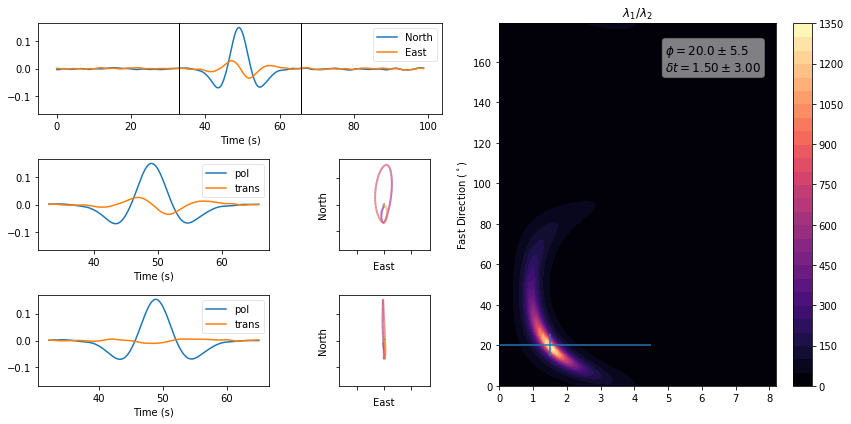

In [14]:
m.plot()

In [7]:
m.srcpoldata().chop()